In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(30,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0




buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.01)
solver = PennylaneSolver(3, combinatorial_only=True)

env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic(seed_val=.5)
n_qubits = 3
solver = PennylaneSolver(n_qubits, combinatorial_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0001)

@tf.function
def step(labels,states):
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(states)
        loss = tf.reduce_mean(tf.keras.losses.MSE(labels,qpreds))
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss

#this is written very cumbersome since I tried to use @tf.function, but in the end i'm not using it here
#since i get an error when sweeping the actions.
def give_labels(critic, buffer, batch_size=16):
    batch = buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)
    rws = tf.convert_to_tensor(rewards.astype(np.float32))
    nextq = tf.math.reduce_max(critic_target(tf.stack(next_states)), axis=1)
    states = tf.stack(states)
    dones = tf.constant(list(dones))

    labels = critic(states)
    tst=[]
    for ind, ac_ind in enumerate(actions):
        pts = tf.unstack(tf.unstack(labels)[ind])
        if dones[ind] == True:
            pts[ac_ind] = rws[ind]
        else:
            pts[ac_ind] = nextq[ind]
        pts = tf.stack(pts)
        tst.append(pts)
    labels = tf.stack(tst, axis=0)
    return labels,tf.stack(states)

env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,3000,1)
tt = .75*len(episodes)/np.log(1/0.05)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.1, np.exp(-k/tt))
lhist=[]
for k in tqdm(episodes):
    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=schedule(k))
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    labels,states = give_labels(critic, buffer)
    l=step(labels,states)
    lhist.append(l.numpy())
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    


  0%|          | 4/2999 [00:00<09:06,  5.48it/s]

  0%|          | 5/2999 [00:00<08:09,  6.11it/s]

  0%|          | 6/2999 [00:00<07:57,  6.27it/s]

  0%|          | 7/2999 [00:01<07:58,  6.25it/s]

100%|██████████| 2999/2999 [01:49<00:00, 27.41it/s]


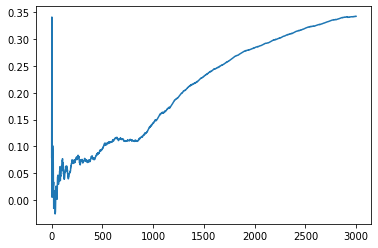

In [24]:
plt.plot(r/episodes)

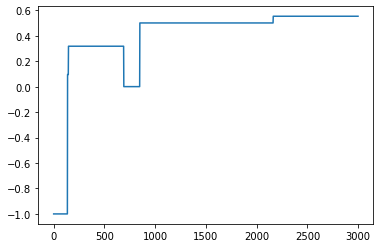

In [25]:
plt.plot(pt)

In [26]:
state = env.reset()
done = False
while not done:
    action = critic.give_action(state, ep=0)
    next_state, reward, done, info = env.step(action)
    state = next_state


In [28]:
state*8

array([0., 1., 2., 3., 4., 5., 4., 5., 6.], dtype=float32)

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import PennylaneSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm


warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.01, seed_val = 0.05):
        super(Critic,self).__init__()

        self.tau = tau
        self.l1 = Dense(60,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        
        self.l2 = Dense(60,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        
        self.l3 = Dense(8, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
                        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01):
        if np.random.random() < ep:
            random_action = np.random.choice(range(8))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy

    def call(self, inputs):
        feat = tf.nn.relu(self.l1(inputs))
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.tanh(self.l3(feat))
        return feat



class ReplayBuffer():
    def __init__(self, buffer_size=10**3):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch

    def clear(self):
        self.buffer.clear()
        self.count = 0




buffer = ReplayBuffer()
critic = Critic()
critic_target = Critic(tau=0.01)
solver = PennylaneSolver(3, combinatorial_only=True)

env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)


buffer = ReplayBuffer()
critic = Critic(seed_val=.5)
n_qubits = 3
solver = PennylaneSolver(n_qubits, combinatorial_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.01)

@tf.function
def step(labels,states):
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(states)
        loss = tf.reduce_mean(tf.keras.losses.MSE(labels,qpreds))
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    return loss

#this is written very cumbersome since I tried to use @tf.function, but in the end i'm not using it here
#since i get an error when sweeping the actions.
def give_labels(critic, buffer, batch_size=16):
    batch = buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)
    rws = tf.convert_to_tensor(rewards.astype(np.float32))
    nextq = tf.math.reduce_max(critic_target(tf.stack(next_states)), axis=1)
    states = tf.stack(states)
    dones = tf.constant(list(dones))

    labels = critic(states)
    tst=[]
    for ind, ac_ind in enumerate(actions):
        pts = tf.unstack(tf.unstack(labels)[ind])
        if dones[ind] == True:
            pts[ac_ind] = rws[ind]
        else:
            pts[ac_ind] = nextq[ind]
        pts = tf.stack(pts)
        tst.append(pts)
    labels = tf.stack(tst, axis=0)
    return labels,tf.stack(states)

env = VansEnv(solver, 8, mdp_length=2, state_as_sequence=True, printing=False)

r=[]
pt=[]
cumre=0
episodes = np.arange(1,10**3,1)
tt = .75*len(episodes)/np.log(1/0.05)
def schedule(k):
    if k< 10:
        return 1
    else:
        return max(0.01, np.exp(-k/tt))
lhist=[]
for k in tqdm(episodes):
    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0.01)
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)

    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state

    labels,states = give_labels(critic, buffer)
    l=step(labels,states)
    lhist.append(l.numpy())
    critic_target.update_target_parameters(critic)

    pt.append(reward)
    


  0%|          | 4/2999 [00:00<09:00,  5.54it/s]

  0%|          | 5/2999 [00:00<08:27,  5.90it/s]

  0%|          | 6/2999 [00:00<08:27,  5.89it/s]

  0%|          | 7/2999 [00:01<08:26,  5.91it/s]

100%|██████████| 2999/2999 [01:41<00:00, 29.53it/s]


In [67]:
batch =buffer.sample(20)
states, actions, next_states, rewards, dones = np.transpose(batch)


In [68]:
rewards

array([0, 0.05566933296151461, 0, 0, 0, -1, 0.09493743739106493, 0, 0, 0,
       0.09493743739106493, 0, 0, 0.05566933296151461,
       0.05566933296151461, 0, 0, 0.44462534316398106, -1, 0],
      dtype=object)

In [ ]:

qpreds = critic(tf.stack(states))
labels = qpreds.numpy()
for inda, act in enumerate(actions):
    if dones[inda] is False:
        labels[inda,act] = critic.give_action(next_states[inda], ep=0)
    else:
        labels[inda, act] = rewards[inda]

In [62]:
next_state

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.5  , 0.75 , 0.875],
      dtype=float32)

In [34]:
state = env.reset()
done = False
k=0
actions=[6,7]
while not done:
    action = actions[k]
    k+=1
    next_state, reward, done, info = env.step(action)
    state = next_state


In [39]:
alls = buffer.sample(buffer.count)

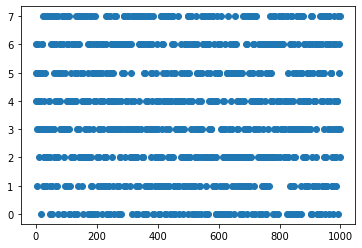

In [46]:
plt.scatter(range(len(np.transpose(alls)[1])), np.transpose(alls)[1])

In [47]:
import pandas as pd

In [50]:
np.histogram(np.transpose(alls)[1], bins=8)

(array([101, 109, 134, 138, 137, 113, 143, 125]),
 array([0.0, 0.875, 1.75, 2.625, 3.5, 4.375, 5.25, 6.125, 7.0],
       dtype=object))

In [51]:
np.transpose(alls)[1]

array([5, 6, 4, 3, 1, 5, 4, 6, 5, 3, 5, 4, 2, 4, 4, 4, 0, 3, 5, 6, 3, 6,
       5, 1, 7, 3, 2, 4, 2, 1, 7, 5, 2, 3, 1, 1, 7, 3, 7, 7, 2, 2, 3, 4,
       4, 3, 0, 1, 2, 0, 7, 6, 7, 0, 1, 7, 6, 6, 3, 3, 5, 2, 7, 4, 7, 2,
       6, 1, 1, 4, 2, 5, 2, 0, 7, 5, 5, 4, 3, 4, 6, 6, 6, 5, 3, 7, 3, 5,
       0, 6, 3, 7, 7, 2, 0, 1, 5, 3, 7, 3, 3, 4, 4, 6, 1, 6, 7, 6, 3, 7,
       0, 1, 4, 0, 5, 4, 2, 4, 2, 4, 6, 6, 2, 6, 6, 4, 2, 0, 4, 6, 5, 5,
       4, 7, 0, 5, 3, 7, 6, 3, 1, 6, 2, 3, 2, 2, 7, 5, 5, 7, 7, 2, 1, 4,
       4, 5, 0, 7, 4, 2, 2, 7, 2, 3, 3, 4, 4, 2, 4, 7, 6, 5, 0, 2, 3, 2,
       4, 0, 7, 6, 1, 2, 0, 7, 1, 0, 5, 3, 6, 5, 4, 0, 5, 5, 7, 4, 4, 5,
       5, 6, 5, 2, 0, 1, 6, 5, 3, 3, 5, 2, 3, 4, 5, 6, 1, 4, 0, 5, 6, 6,
       4, 3, 4, 1, 2, 1, 2, 2, 1, 2, 6, 7, 5, 0, 7, 0, 4, 3, 1, 1, 4, 5,
       7, 0, 3, 5, 6, 4, 5, 3, 6, 2, 3, 5, 1, 4, 0, 4, 7, 6, 6, 4, 7, 6,
       3, 3, 3, 6, 1, 4, 0, 6, 6, 1, 0, 3, 2, 3, 2, 6, 0, 4, 5, 6, 6, 6,
       5, 3, 5, 7, 1, 7, 6, 6, 2, 1, 4, 3, 6, 4, 3,

array([-0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125,
       -0.125], dtype=float32)

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125, -0.125,
        -0.125]], dtype=float32)>

In [60]:
critic(tf.expand_dims(env.state,axis=0))

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[0.36894906, 0.30802962, 0.27983195, 0.236437  , 0.23071098,
        0.2574616 , 0.30446997, 0.37027442]], dtype=float32)>